#### 1. Import the lib's

In [1]:
import pandas as pd
import numpy as np
from random import seed
from random import sample
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gensim.downloader as api
from gensim.models.keyedvectors import Word2VecKeyedVectors
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from scipy import spatial
from nltk.corpus import stopwords

#### 2. Set the seed value

In [2]:
seed(42)
np.random.seed(42)


#### 3. Loading the word2Vec model

In [3]:
model2 = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
model2

#### 4. Dataframe loading from the json

In [40]:
df= pd.read_csv('data_fewshots.csv',lineterminator='\n')
#df
#df.drop(columns=['Unnamed: 0'],inplace= True)
#df.columns
df

,Unnamed: 0,Email Body,Label
0,0,"Sir,I didnt receive refund for failed train bo...",2
1,1,Enter your Yatra Ref number = Intera...,2
2,2,"Dear Team,Kindly activate my rail id for ERP C...",2
3,3,Enter your Yatra Ref number = yatraRefNo ...,2
4,4,Reply: RE:'YA:30893404' CDXDFGVCJVCHGFJHNB30-D...,2
...,...,...,...
668,668,"Respected sir / madam ,Please continue replyin...",4
669,669,"Respected sir / madam ,Please continue replyin...",4
670,670,"Hi Team,Any update on this?Thank YouSohanOn We...",4
671,671,"Hi Yatra Team,I was a bit disappointed when bo...",4


#### 5. Data cleaning 

In [41]:
import regex as re

#### 5.1 Get only chars and remove all special chars

In [42]:
def get_only_chars(line):

    # Make the empty string
    clean_line = ""

    # Replace single inverted comma with truncated space
    line = line.replace("’", "")

    # Replace inverted comma with truncated space
   # line = line.replace("'", "")

    # Replace inverted hyphens with truncated space
    line = line.replace("-", " ") 

    # Replace horizontal tab with truncated space
    line = line.replace("\t", " ")

    # Replace new line with truncated space
    line = line.replace("\n", " ")

    # Make everything in lower case
    line = line.lower()

    # For every char there should not be any number
    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '

    # Delete the extra spaces
    clean_line = re.sub(' +',' ',clean_line) #delete extra spaces
    if clean_line[0] == ' ':
        clean_line = clean_line[1:]

    # Finally return the cleaned text
    return clean_line

#### 5.2 Text conversion


In [45]:
df["Text"] = df["Email Body"].astype(str)
df.drop(columns=['Email Body','Unnamed: 0'],inplace= True)
df

,Label,Text
0,2,"Sir,I didnt receive refund for failed train bo..."
1,2,Enter your Yatra Ref number = Intera...
2,2,"Dear Team,Kindly activate my rail id for ERP C..."
3,2,Enter your Yatra Ref number = yatraRefNo ...
4,2,Reply: RE:'YA:30893404' CDXDFGVCJVCHGFJHNB30-D...
...,...,...
668,4,"Respected sir / madam ,Please continue replyin..."
669,4,"Respected sir / madam ,Please continue replyin..."
670,4,"Hi Team,Any update on this?Thank YouSohanOn We..."
671,4,"Hi Yatra Team,I was a bit disappointed when bo..."


#### 5.3 Apply on the text feature to clean the data

In [46]:
df['Text'] = df['Text'].apply(lambda x: get_only_chars(x))
df

,Label,Text
0,2,sir i didnt receive refund for failed train bo...
1,2,enter your yatra ref number interaction type o...
2,2,dear team kindly activate my rail id for erp c...
3,2,enter your yatra ref number yatrarefno interac...
4,2,reply re ya cdxdfgvcjvchgfjhnb domestic flight...
...,...,...
668,4,respected sir madam please continue replying o...
669,4,respected sir madam please continue replying o...
670,4,hi team any update on this thank yousohanon we...
671,4,hi yatra team i was a bit disappointed when bo...


#### 6. Label counts

In [47]:
df['Label'].value_counts()

3    392
1    136
2     76
4     69
Name: Label, dtype: int64

#### 7. Define the no of classes and samples/class

In [94]:
# K way : support set has k classes
# n-shot : every class has n samples
# 2 way 3 shot 
num_classes = 2
sample_size = 3
# Graph - Accuracy vs no of ways(i.e no of samples)

#Note.
# 1. As no of classes increases acccuracy drops down 
# 2. Because making choices from small set is more easy than from a biggger set


# Graph - Accuracy vs no of shots(i.e no of shots)

# 1. With more samples predicction becomes eaiser
# 2. Therefore the accuracy inccreases with  no of shots

#### 8. Generate the samples

In [95]:
# Generate samples that contains K samples of each class

def gen_sample(sample_size, num_classes):

    df_1 = df[(df["Label"]<num_classes + 1)].reset_index().drop(["index"], axis=1).reset_index().drop(["index"], axis=1)
    train = df_1[df_1["Label"] == np.unique(df_1['Label'])[0]].sample(sample_size)
    

    train_index = train.index.tolist()

    for i in range(1,num_classes):
        train_2 = df_1[df_1["Label"] == np.unique(df_1['Label'])[i]].sample(sample_size)
        train = pd.concat([train, train_2], axis=0)
        train_index.extend(train_2.index.tolist())

    test = df_1[~df_1.index.isin(train_index)]

    return train, test

#### 9. Train and test

In [96]:
train, test = gen_sample(sample_size, num_classes)

X_train = train['Text']
y_train = train['Label'].values
X_test = test['Text']
y_test = test['Label'].values

In [97]:
train

,Label,Text
187,1,it is not dynamic issue im not new to flight b...
162,1,thank you for your response but now i got info...
205,1,hi please refer to yatra reference number ta t...
22,2,hi team i was trying book train tickets throug...
47,2,enter your yatra ref number interaction type r...
17,2,dear team still i havent got the payment kindl...


In [90]:
len(train)

12

In [98]:
test

,Label,Text
0,2,sir i didnt receive refund for failed train bo...
1,2,enter your yatra ref number interaction type o...
2,2,dear team kindly activate my rail id for erp c...
3,2,enter your yatra ref number yatrarefno interac...
4,2,reply re ya cdxdfgvcjvchgfjhnb domestic flight...
...,...,...
207,1,dear sender thanks for your e mail i am on lea...
208,1,fya on am from tejaswini molli stl tech to sup...
209,1,fya on am from tejaswini molli stl tech to sup...
210,1,fya on am from tejaswini molli stl tech to sup...


#### 10.  Transform sentence

In [99]:
# Text processing (split, find token id, get embedidng)
def transform_sentence(text, model):

    """
    Mean embedding vector
    """

    def preprocess_text(raw_text, model=model):

        """ 
        Excluding unknown words and get corresponding token
        """

        raw_text = raw_text.split()

        return list(filter(lambda x: x in model.vocab, raw_text))

    tokens = preprocess_text(text)

    if not tokens:
        return np.zeros(model.vector_size)

    text_vector = np.mean(model[tokens], axis=0)

    return np.array(text_vector)

#### 11. Compute the mean of train and test

In [100]:
X_train_mean = X_train.apply(lambda x : transform_sentence(x, model2))
X_test_mean = X_test.apply(lambda x : transform_sentence(x, model2))

X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)

#### 12. Compute the consine similarity

In [101]:
# Use cosine similarity to find closest class
def classify_txt(txt, mean_embedding):

    best_dist = 1
    best_label = -1

    for cl in range(num_classes):

        dist = spatial.distance.cosine(transform_sentence(txt, model2), mean_embedding[cl])

        if dist < best_dist :
            best_dist = dist
            best_label = cl+1

    return best_label

#### 13. Return the score


In [109]:
# Process text and predict on the test set
def return_score(sample_size, num_classes):

    train, test = gen_sample(sample_size, num_classes)

    X_train = train['Text']
    y_train = train['Label'].values
    X_test = test['Text']
    y_test = test['Label'].values

    X_train_mean = X_train.apply(lambda x : transform_sentence(x, model2))
    X_test_mean = X_test.apply(lambda x : transform_sentence(x, model2))

    X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
    X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)

    mean_embedding = {}
    for cl in range(num_classes):
        print('cl: {} '.format(str(cl)) )
        mean_embedding[cl] = np.mean((X_train_mean[y_train == cl + 1]), axis=0)

    y_pred = [classify_txt(t, mean_embedding) for t in test['Text'].values]

    return accuracy_score(y_pred, y_test)

#### 14. Compute the accuracy


In [134]:
# all_accuracy = {2:[],3:[],4:[],5:[],6:[],7:[]}
all_accuracy = {2:[],3:[],4:[], 5:[]}

for num_samples in range(1,69):
    for num_cl in range(2, 5):
        #print("num_cl : {}".format(str(num_cl)))
        all_accuracy[num_cl].append(return_score(num_samples,num_cl))

#### 15. Plot the performance based on number of classes and samples per class

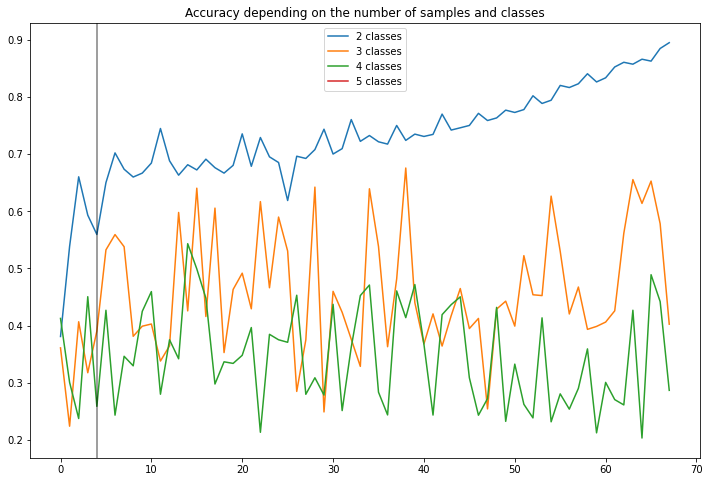

In [135]:
plt.figure(figsize=(12,8))

plt.plot(all_accuracy[2], label="2 classes")
plt.plot(all_accuracy[3], label="3 classes")
plt.plot(all_accuracy[4], label="4 classes")
plt.plot(all_accuracy[5], label="5 classes")

plt.axvline(4, c='black', alpha=0.5)
plt.title("Accuracy depending on the number of samples and classes")
plt.legend()
plt.show()


#### 16. Apply the KNN

In [136]:
from sklearn.neighbors import KNeighborsClassifier

def return_score_knn(sample_size, num_classes):

    train, test = gen_sample(sample_size, num_classes)

    X_train = train['Text']
    y_train = train['Label'].values
    X_test = test['Text']
    y_test = test['Label'].values

    X_train_mean = X_train.apply(lambda x : transform_sentence(x, model2))
    X_test_mean = X_test.apply(lambda x : transform_sentence(x, model2))

    X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
    X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)

    clf = KNeighborsClassifier(n_neighbors=sample_size, p=2)
    clf.fit(X_train_mean, y_train)

    y_pred = clf.predict(X_test_mean)

    return accuracy_score(y_pred, y_test)

#### 17. Again compute the accuracy for KNN

In [138]:
# all_accuracy = {2:[],3:[],4:[],5:[],6:[],7:[]}
all_accuracy_knn = {2:[],3:[],4:[], 5:[]}

for num_samples in range(1,70):
    for num_cl in range(2, 5):
        #print("num_cl : {}".format(str(num_cl)))
        all_accuracy_knn[num_cl].append(return_score_knn(num_samples,num_cl))

#### 18. Plot the performance of no of classes vs no of samples per class

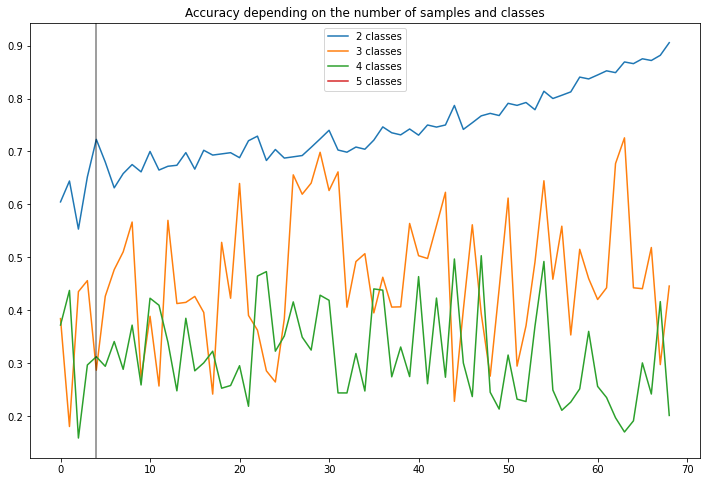

In [139]:
plt.figure(figsize=(12,8))
plt.plot(all_accuracy_knn[2], label="2 classes")
plt.plot(all_accuracy_knn[3], label="3 classes")
plt.plot(all_accuracy_knn[4], label="4 classes")
plt.plot(all_accuracy_knn[5], label="5 classes")
# plt.plot(all_accuracy[6], label="6 classes")
plt.axvline(4, c='black', alpha=0.5)
plt.title("Accuracy depending on the number of samples and classes")
plt.legend()
plt.show()
